# A nonlinear ANN equalizer with mini-batch gradient descent in 40Gbaud PAM-8 IM/DD system

Nesse notebook, será implementada uma simulação de um sistema ótpico de transmissão de recepção IM/DD para um sinal de 40Gbaud, com modulação de amplitude de 8 níveis.

Então será analisado o desempenho de diferentes tipos de rede

In [1]:
import numpy as np
from optic.torchUtils import slidingWindowDataSet, MLP
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, ConcatDataset
from optic.comm.modulation import GrayMapping, modulateGray, demodulateGray
from optic.dsp.core import pulseShape, lowPassFIR, pnorm, signal_power
from optic.utils import parameters, dBm2W
from optic.models.devices import mzm, photodiode, edfa
from optic.comm.modulation import GrayMapping, modulateGray, demodulateGray

from tqdm.notebook import tqdm
from commpy.utilities  import upsample
from optic.dsp.core import firFilter
from optic.models.channels import linearFiberChannel
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import OpticFunctions as of
import importlib
import IPython.display as ipd

In [3]:
importlib.reload(of)

<module 'OpticFunctions' from 'C:\\Users\\jezra\\Redes Neurais - Pytorch\\OpticFunctions.py'>

In [4]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

figsize(10, 3)

In [5]:
# %load_ext autoreload
# %autoreload 2

In [6]:
np.random.seed(seed=123)

In [7]:
# Parâmetros para geração de sinal
SpS = 2
Rs = 40*10^9
M = 8

#Parâmetros para Canal de Transmissão
dist4 = 4
dist12 = 12
dist8 = 8

## Para fibra de 8 km

In [8]:
sinalTx8, symbTx8 = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M =M)

SymbTx antes da normalização:  [-1. -7. -3. ... -1. -7. -1.]


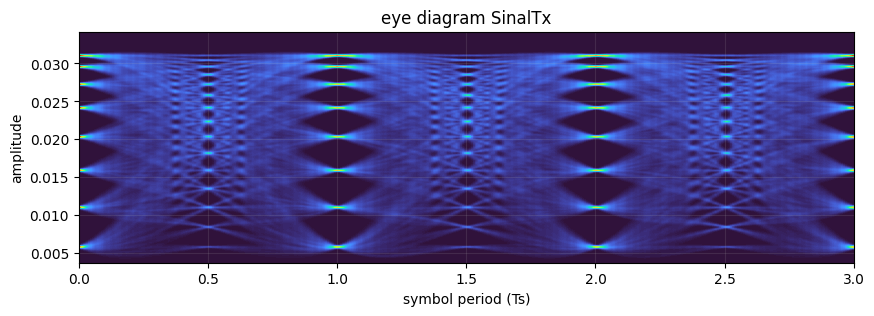

In [9]:
of.PlotEyediagram(sinalTx8, SpS, 'SinalTx')

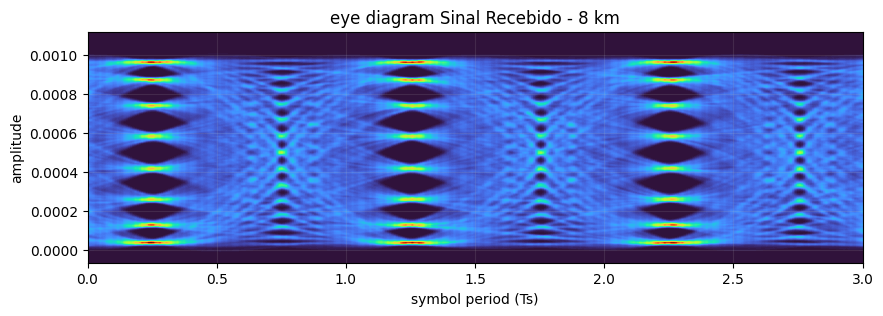

In [10]:
sinal8 = of.SimulaCanalOptico(sinal = sinalTx8, SpS = SpS, Rs = Rs, dist_fibra = dist8,)
of.PlotEyediagram(sinal8, SpS = SpS, label = 'Sinal Recebido - 8 km')

## Para fibra de 4 km

In [11]:
sinalTx4, symbTx4 = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M =M, Pi_dBm = -5)

SymbTx antes da normalização:  [ 7. -5. -1. ...  3. -5.  3.]


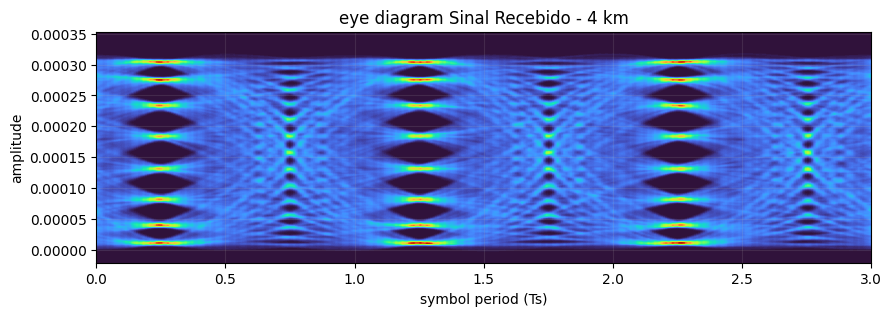

In [12]:
sinal4 = of.SimulaCanalOptico(sinal = sinalTx4, SpS = SpS, Rs = Rs, dist_fibra = dist4)
of.PlotEyediagram(sinal4, SpS = SpS, label = 'Sinal Recebido - 4 km')

Number of counted errors = 465452 
BER = 1.55e-01 


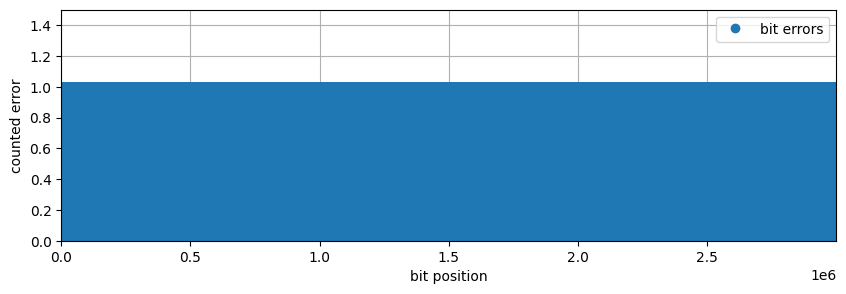

In [13]:
bitstx4 = of.RecuperaBits(sinalTx4, SpS, M)
bitsrx4 = of.RecuperaBits(sinal4, SpS, M)
of.CalculaBER(bitstx4, bitsrx4)

## Para fibra de 12 km

In [14]:
sinalTx12, symbTx12 = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M =M)

SymbTx antes da normalização:  [ 3.  7. -3. ... -5.  3. -3.]


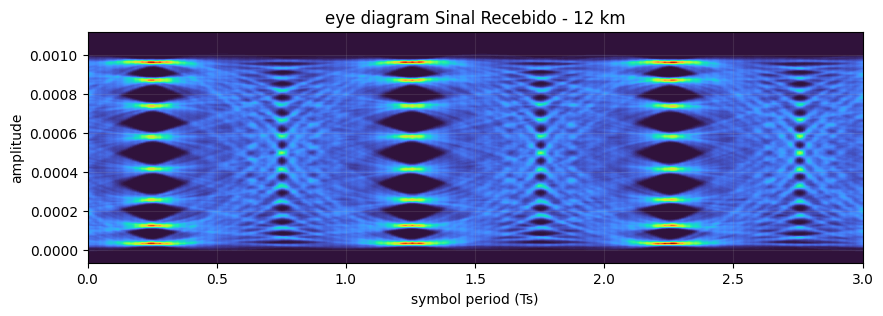

In [15]:
sinal12 = of.SimulaCanalOptico(sinal = sinalTx12, SpS = SpS, Rs = Rs, dist_fibra = dist12)
of.PlotEyediagram(sinal12, SpS = SpS, label = 'Sinal Recebido - 12 km')

In [16]:
Ntaps = 2
batch_size = 200
shuffle = True
shuffle_full = False

train_dataset4, test_dataset4, full_dataset4 = of.CriaDataSet(symbTx4, sinal4, SpS, Ntaps = Ntaps)
train_dataset8, test_dataset8, full_dataset8 = of.CriaDataSet(symbTx8, sinal8, SpS, Ntaps = Ntaps)
train_dataset12, test_dataset12, full_dataset12 = of.CriaDataSet(symbTx12, sinal12, SpS, Ntaps = Ntaps)

comb_train_ds = ConcatDataset([train_dataset4, train_dataset8, train_dataset12])
comb_test_ds = ConcatDataset([test_dataset4, test_dataset8, test_dataset12])

train_dataloader = DataLoader(comb_train_ds, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(comb_test_ds, batch_size=batch_size, shuffle=shuffle)

full_dataloader_4 = DataLoader(full_dataset4, batch_size=len(full_dataset4), shuffle=shuffle_full)
full_dataloader_8 = DataLoader(full_dataset8, batch_size =len(full_dataset8), shuffle = shuffle_full)
full_dataloader_12 = DataLoader(full_dataset12, batch_size =len(full_dataset12), shuffle = shuffle_full)

In [17]:
for batch in full_dataloader_4:
    # Extrair as amostras do lote
    inputs, targets = batch

    # Verificar o formato das amostras
    print("Formato das entradas:", inputs.shape)
    print("Formato dos alvos:", targets.shape)

    # Parar a iteração após a primeira amostra (opcional)
    break

Formato das entradas: torch.Size([1000000, 2])
Formato dos alvos: torch.Size([1000000, 1])


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# RNN

## Classe

In [19]:
    class RNN(nn.Module):
        def __init__(self, input_size, hidden_size, output_size, num_layers):
            super(RNN, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            h0 = torch.zeros(self.num_layers, self.hidden_size).to(device)
            # Passar os dados pela RNN
            out, h_n = self.rnn(x, h0)  # h_n é o estado oculto final da última etapa de tempo

            # Passar a saída da RNN pela camada linear
            out = self.fc(out)
            return out


In [20]:
input_size = Ntaps
hidden_size = 120
output_size = input_size//SpS
num_layers = 2
modelo_rnn = RNN(input_size, hidden_size, output_size, num_layers).to(device)

## Método de Treinamento

In [21]:
loss_fn = nn.MSELoss()
optimizer_rnn = torch.optim.Adam(modelo_rnn.parameters(), lr = 0.0025)
epochs_rnn = 4
cada_print = 5000

In [23]:
def train_loop_rnn(train_dataloader, model, loss, optimizer, cada_print):
    size = len(train_dataloader.dataset)
    
    model.train()
    for batch, (x, y) in enumerate(train_dataloader):
        x, y = x.float().to(device), y.float().to(device)
        predict = model(x)

        print(predict.shape)
        loss_value = loss(predict, y)
        
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % cada_print == 0:
            loss_value, current = loss_value.item(), (batch+1)*len(x)
            print(f"loss: {loss_value:>7f}[{current:>5d}/{size:>5d}]" )
def test_loop_rnn(progress_dataloader, equalizer, loss):
    size = len(progress_dataloader.dataset)
    num_batches = len(progress_dataloader)
    equalizer.eval()
    eval_loss = 0
    with torch.no_grad():
        for x, y in progress_dataloader:
            x, y = x.float().to(device), y.float().to(device)
            pred = equalizer(x)
            eval_loss += loss(pred, y).item()
    eval_loss /= num_batches
    print(f"Perda média: {eval_loss:>8f} \n")

In [26]:
'''
for t in range(epochs_rnn):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader, modelo_rnn, loss_fn, optimizer_rnn, cada_print)
    of.test_loop(test_dataloader, modelo_rnn, loss_fn)
print("Pronto!")

framerate = 44100
t = np.linspace(0,1,framerate*1)
data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
ipd.Audio(data,rate=framerate, autoplay=True)'''

Época 1
-------------------------------
loss: 0.956821[  200/2400000]
loss: 0.011289[1000200/2400000]
loss: 0.008601[2000200/2400000]
Perda média: 0.005045 

Época 2
-------------------------------
loss: 0.005185[  200/2400000]
loss: 0.005017[1000200/2400000]
loss: 0.001457[2000200/2400000]
Perda média: 0.000526 

Época 3
-------------------------------
loss: 0.000954[  200/2400000]
loss: 0.000414[1000200/2400000]
loss: 0.000433[2000200/2400000]
Perda média: 0.000381 

Época 4
-------------------------------
loss: 0.000501[  200/2400000]
loss: 0.001772[1000200/2400000]
loss: 0.000439[2000200/2400000]
Perda média: 0.002314 

Pronto!


In [27]:
modelo_rnn = torch.load('model_RNN.pth')

In [28]:
#torch.save(modelo_rnn, 'model_RNN.pth')

In [29]:
def RetornaSinalEqualizado(modelo_rnn, dataloader):
    modelo_rnn.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.float()
            pred = modelo_rnn(X)

            symbRx_NN = pred

            symbRx_NN = symbRx_NN.numpy().reshape(-1,)
    return symbRx_NN

Number of counted errors = 9064 
BER = 3.02e-03 


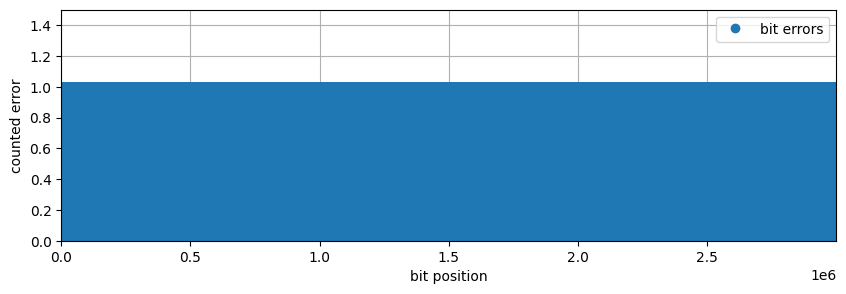

In [30]:
symb_rnn = RetornaSinalEqualizado(modelo_rnn, full_dataloader_8)
const = GrayMapping(M, 'pam') 
Es = signal_power(const)
#print(symb_rx_nn.shape)
bits_rx_nn = demodulateGray(np.sqrt(Es)*pnorm(symb_rnn), M, 'pam')
bitt = demodulateGray(np.sqrt(Es)*pnorm(symbTx8), M, 'pam')

of.CalculaBER(bitt, bits_rx_nn)

# MLP

In [31]:
#modelo_mlp = MLP([Ntaps, 10, 1])

In [32]:
modelo_mlp = torch.load('Model_MLP.pth')

In [33]:
optimizer_mlp = torch.optim.Adam(modelo_mlp.parameters(), lr = 0.0025)
epochs_mlp = 5

In [34]:
'''
for t in range(epochs_mlp):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader, modelo_mlp, loss_fn, optimizer_mlp, cada_print)
    of.test_loop(test_dataloader, modelo_mlp, loss_fn)
print("Pronto!")
framerate = 44100
t = np.linspace(0,1,framerate*1)
data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
ipd.Audio(data,rate=framerate, autoplay=True)'''

Época 1
-------------------------------
loss: 1.113470[  200/2400000]
loss: 0.005633[1000200/2400000]
loss: 0.004948[2000200/2400000]
Perda média: 0.004744 

Época 2
-------------------------------
loss: 0.005172[  200/2400000]
loss: 0.005074[1000200/2400000]
loss: 0.004138[2000200/2400000]
Perda média: 0.004589 

Época 3
-------------------------------
loss: 0.005477[  200/2400000]
loss: 0.005057[1000200/2400000]
loss: 0.003955[2000200/2400000]
Perda média: 0.004529 

Época 4
-------------------------------
loss: 0.004738[  200/2400000]
loss: 0.005267[1000200/2400000]
loss: 0.004910[2000200/2400000]
Perda média: 0.004344 

Época 5
-------------------------------
loss: 0.004703[  200/2400000]
loss: 0.005203[1000200/2400000]
loss: 0.004128[2000200/2400000]
Perda média: 0.004301 

Pronto!


In [35]:
#torch.save(modelo_mlp, 'Model_MLP.pth')

Number of counted errors = 1783 
BER = 5.94e-04 


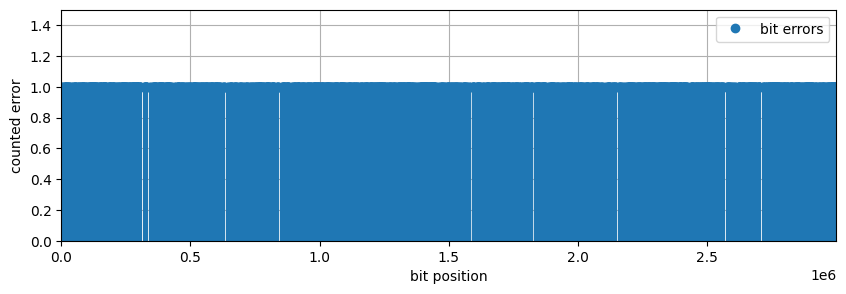

In [36]:
symb_mlp = of.GeraSinalEqualizado(modelo_mlp, full_dataloader_8)
const = GrayMapping(M, 'pam') 
Es = signal_power(const)
#print(symb_rx_nn.shape)
bitsRxMlp = demodulateGray(np.sqrt(Es)*pnorm(symb_mlp), M, 'pam')
bitt = demodulateGray(np.sqrt(Es)*pnorm(symbTx8), M, 'pam')

of.CalculaBER(bitt, bitsRxMlp)

In [37]:
#modelo_mlp2 = MLP([Ntaps, 20, 10, 1])

In [38]:
modelmlp2 = torch.load('model_MLP2.pth')

In [39]:
'''
optimizer_mlp2 = torch.optim.Adam(modelo_mlp2.parameters(), lr = 0.0025)
for t in range(epochs_mlp):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader, modelo_mlp2, loss_fn, optimizer_mlp2, cada_print)
    of.test_loop(test_dataloader, modelo_mlp2, loss_fn)
print("Pronto!")
ipd.Audio(data,rate=framerate, autoplay=True)'''

Época 1
-------------------------------
loss: 1.157769[  200/2400000]
loss: 0.003909[1000200/2400000]
loss: 0.003788[2000200/2400000]
Perda média: 0.003918 

Época 2
-------------------------------
loss: 0.003760[  200/2400000]
loss: 0.003417[1000200/2400000]
loss: 0.003526[2000200/2400000]
Perda média: 0.002991 

Época 3
-------------------------------
loss: 0.003034[  200/2400000]
loss: 0.003246[1000200/2400000]
loss: 0.003174[2000200/2400000]
Perda média: 0.002537 

Época 4
-------------------------------
loss: 0.003094[  200/2400000]
loss: 0.002684[1000200/2400000]
loss: 0.002730[2000200/2400000]
Perda média: 0.002382 

Época 5
-------------------------------
loss: 0.002147[  200/2400000]
loss: 0.001844[1000200/2400000]
loss: 0.001943[2000200/2400000]
Perda média: 0.002284 

Pronto!


In [40]:
#torch.save(modelo_mlp2, 'model_MLP2.pth')

Number of counted errors = 1764 
BER = 5.88e-04 


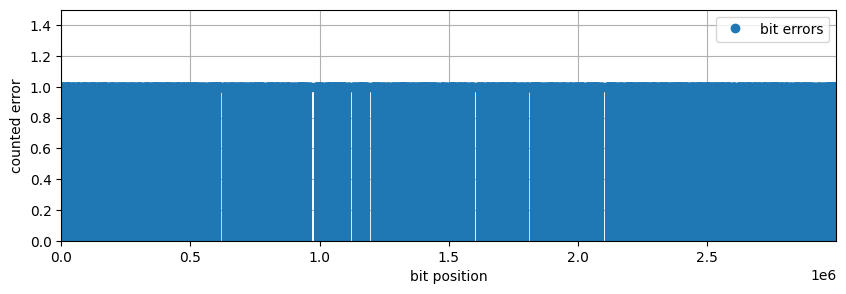

In [41]:
symb_mlp2 = of.GeraSinalEqualizado(modelo_mlp2, full_dataloader_8)
const = GrayMapping(M, 'pam') 
Es = signal_power(const)
#print(symb_rx_nn.shape)
bitsRxMlp2 = demodulateGray(np.sqrt(Es)*pnorm(symb_mlp2), M, 'pam')
bitt = demodulateGray(np.sqrt(Es)*pnorm(symbTx8), M, 'pam')

of.CalculaBER(bitt, bitsRxMlp2)

In [46]:
discard = 100
distance = np.arange(4, 12)
BER = np.zeros(distance.size)
BER_RNN = np.zeros(distance.size)
BER_MLP = np.zeros(distance.size)
BER_MLP2 = np.zeros(distance.size)
power = -2
Ntaps = 2
const = GrayMapping(M, 'pam') 
Es = signal_power(const)

sinaltx, symbtx = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M = M, Pi_dBm = power)
for ind, dist in enumerate(distance):
    
    irx = of.SimulaCanalOptico(sinaltx, SpS = SpS, Rs = Rs, dist_fibra = dist)
    
    bitstx = of.RecuperaBits(sinaltx, SpS, M)
    bitsrx = of.RecuperaBits(irx, SpS, M)
    
    err = np.logical_xor(bitsrx[discard:bitsrx.size-discard], bitstx[discard:bitstx.size-discard])
    BER[ind] = np.mean(err)
    
    print('BER = %.2e '%(BER[ind]))
    '''
    signalrx = pnorm(irx[0::SpS//SpS_out])
    signalrx= (signalrx - np.mean(signalrx))/np.std(signalrx)
    
    dataset = slidingWindowDataSet(signalrx, symbtx, Ntaps, SpS_out)
    
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    '''
    treino_dataset, teste_dataset, dataset = of.CriaDataSet(symbtx, irx, SpS, Ntaps = Ntaps)
    
    dataloader = DataLoader(dataset, batch_size =len(dataset), shuffle = False)
    
    #RNN
    symb_RNN = RetornaSinalEqualizado(modelo_rnn, dataloader)
    bits_RNN = demodulateGray(np.sqrt(Es)*pnorm(symb_RNN), M, 'pam')

    
    err = np.logical_xor(bits_RNN[discard:bits_RNN.size-discard], bitstx[discard:bitstx.size-discard])
    BER_RNN[ind] = np.mean(err)

    
    print('BER_RNN = %.2e '%(BER_RNN[ind]))
    
    #MLP
    symb_MLP = of.GeraSinalEqualizado(modelo_mlp, dataloader)
    bits_MLP = demodulateGray(np.sqrt(Es)*pnorm(symb_MLP), M, 'pam')
    
    err = np.logical_xor(bits_MLP[discard:bits_MLP.size-discard], bitstx[discard:bitstx.size-discard])
    BER_MLP[ind] = np.mean(err)

    
    print('BER_MLP = %.2e '%(BER_MLP[ind]))
    
    #MLP2
    symb_MLP2 = of.GeraSinalEqualizado(modelo_mlp2, dataloader)
    bits_MLP2 = demodulateGray(np.sqrt(Es)*pnorm(symb_MLP2), M, 'pam')
    
    err = np.logical_xor(bits_MLP2[discard:bits_MLP2.size-discard], bitstx[discard:bitstx.size-discard])
    BER_MLP2[ind] = np.mean(err)

    
    print('BER_MLP2 = %.2e '%(BER_MLP2[ind]))
    
    

SymbTx antes da normalização:  [ 1. -5. -7. ...  3. -5. -5.]
BER = 1.55e-01 
BER_RNN = 4.49e-02 
BER_MLP = 4.21e-02 
BER_MLP2 = 4.20e-02 
BER = 1.55e-01 
BER_RNN = 4.49e-02 
BER_MLP = 4.21e-02 
BER_MLP2 = 4.20e-02 
BER = 1.55e-01 
BER_RNN = 4.49e-02 
BER_MLP = 4.21e-02 
BER_MLP2 = 4.20e-02 
BER = 1.55e-01 
BER_RNN = 4.49e-02 
BER_MLP = 4.21e-02 
BER_MLP2 = 4.20e-02 
BER = 1.55e-01 
BER_RNN = 4.49e-02 
BER_MLP = 4.21e-02 
BER_MLP2 = 4.20e-02 
BER = 1.55e-01 
BER_RNN = 4.49e-02 
BER_MLP = 4.21e-02 
BER_MLP2 = 4.20e-02 
BER = 1.55e-01 
BER_RNN = 4.49e-02 
BER_MLP = 4.21e-02 
BER_MLP2 = 4.20e-02 
BER = 1.55e-01 
BER_RNN = 4.49e-02 
BER_MLP = 4.21e-02 
BER_MLP2 = 4.20e-02 


Text(0, 0.5, 'log10(BER)')

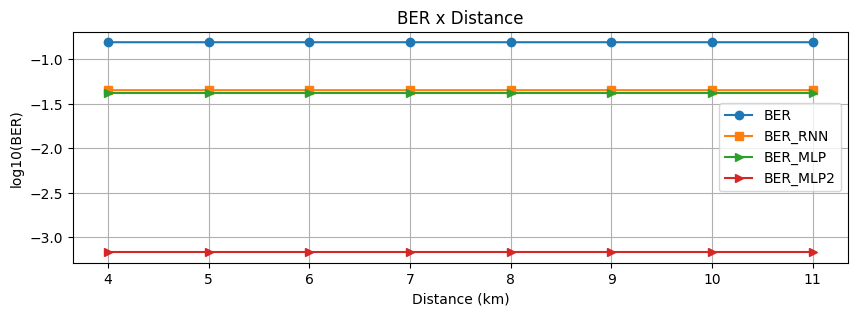

In [47]:
plt.plot(distance, np.log10(BER),'-o', label='BER')
plt.plot(distance, np.log10(BER_RNN),'-s', label='BER_RNN')
plt.plot(distance, np.log10(BER_MLP), '>-', label = 'BER_MLP')
plt.plot(distance, np.log(BER_MLP2), '>-', label = 'BER_MLP2')
plt.grid()
plt.legend();
plt.title('BER x Distance')
plt.xlabel('Distance (km)')
plt.ylabel('log10(BER)')